In [36]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import defaultdict
from math import pi

def nested_dict():
    return defaultdict(nested_dict)

In [37]:
veri_methods = [
    "none",
    "test_acc",
    "shapley",
    "influence",
    "multi_KRUM",
    "update_significance",
    "reproduction",
]

# 配置实验参数组
seeds = [42, 43, 44, 45, 46]
tasks = [1, 2]
maricious_nums = [(4, 0), (1, 0), (0, 4), (0, 1), (2, 2), (0, 0)]
paras = []
for seed in seeds:
    for task in tasks:
        # 添加baseline（不验证+不攻击）
        # paras.append((task, 0, 0, 0, seed))
        # 添加各种验证方法和攻击强度的组合
        for veri_method in [0, 1, 2, 3, 4, 5, 6]:
            for maricious_num in maricious_nums:
                paras.append(
                    (task, veri_method, maricious_num[0], maricious_num[1], seed)
                )

In [38]:
def load_torch_data(save_path):
    if os.path.exists(save_path):
        data = torch.load(save_path)
        return data
    else:
        print(f"File {save_path} does not exist. Skipping loading.")
        return None


def data_preprocess(paras, mode="mapping"):
    # 对于每组实验，预处理实验结果，得到：
    # acc列表、对诚实训练者的验证准确率列表、对恶意训练者的验证准确率列表、模型拥有者效用列表、诚实训练者平均效用列表、恶意训练者平均效用列表
    if mode == "mapping":
        ret = nested_dict()
    else:
        ret = []
    for args in paras:
        save_path = (
            f"./results/task{args[0]}-v{args[1]}-adv{args[2]}-fr{args[3]}-seed{args[4]}"
        )
        data = load_torch_data(save_path)
        if data is None:
            continue
        # print(data["meta"])
        atk_num = data["meta"]["adv"] + data["meta"]["fr"]
        acc = []  # 模型准确率
        veri_acc_honest = []  # 对诚实训练者的验证准确率
        veri_acc_attacker = []  # 对恶意训练者的验证准确率
        mo_utility = []  # 模型拥有者效用
        tn_utilities_honset = []  # 单个诚实训练者平均效用
        tn_utilities_attacker = []  # 单个恶意训练者平均效用
        for epoch_data in data["data"]["epochs"]:
            # 1.获取模型准确率
            acc.append(epoch_data["model_acc"])

            # 2.获取验证准确率
            is_malicious = epoch_data["is_malicious"]
            if atk_num > 0:
                veri_acc_attacker.append(
                    sum(
                        [
                            p == t
                            for p, t in zip(is_malicious[:atk_num], [True] * atk_num)
                        ]
                    )
                    / atk_num
                )
            else:
                veri_acc_attacker.append(1)
            veri_acc_honest.append(
                sum(
                    [
                        p == t
                        for p, t in zip(
                            is_malicious[atk_num:],
                            [False] * (len(is_malicious) - atk_num),
                        )
                    ]
                )
                / (len(is_malicious) - atk_num)
            )

            # 3.获取各角色效用值
            mo_utility.append(epoch_data["mo_utility"])
            if atk_num > 0:
                tn_utilities_attacker.append(
                    np.average(epoch_data["participant_utilities"][:atk_num])
                )
            else:
                tn_utilities_attacker.append(0)
            tn_utilities_honset.append(
                np.average(epoch_data["participant_utilities"][atk_num:])
            )
        item = (
            acc,
            veri_acc_honest,
            veri_acc_attacker,
            mo_utility,
            tn_utilities_honset,
            tn_utilities_attacker,
        )
        if mode == "mapping":
            ret[args[0]][args[1]][args[2]][args[3]][args[4]] = item
        else:
            ret.append(item)
    return ret

In [39]:
ret = data_preprocess(paras)
# print(ret[1][0][0][0][42])

# 按行生成
# task, veri_method, maricious_num[0], maricious_num[1], seed


def construct_TAB(task):
    TAB = []
    for veri_method in [0, 1, 2, 3, 4, 6]:
        TAB_LINE = []
        for maricious_num in [(4, 0), (1, 0), (0, 4), (0, 1), (2, 2), (0, 0)]:
            seed_acc = []  # 各seed最高模型准确率
            seed_veri_acc_ho = []  # 各seed平均验证准确率 诚实
            seed_veri_acc_atk = []  # 各seed平均验证准确率 恶意
            for seed in [43, 44, 45, 46]:
                # 每个单元格获取多个数据
                data = ret[task][veri_method][maricious_num[0]][maricious_num[1]][
                    seed
                ]
                seed_acc.append(np.max(data[0]))
                seed_veri_acc_ho.append(np.average(data[1]))
                seed_veri_acc_atk.append(np.average(data[2]))
            TAB_LINE.append(
                (
                    np.mean(seed_acc),
                    np.std(seed_acc),
                    np.mean(seed_veri_acc_ho),
                    np.std(seed_veri_acc_ho),
                    np.mean(seed_veri_acc_atk),
                    np.std(seed_veri_acc_atk),
                )
            )
        TAB.append(TAB_LINE)
    return TAB


methods = ["None", "TestAcc", "Shapley", "Influence", "multi\_KRUM", "Ours"]
TAB = construct_TAB(1)
for method, line in zip(methods, TAB):
    formatted_data = [tuple(f"{x:.2f}" for x in tup) for tup in line]

    latex_line1 = (
        r"\cmidrule(lr){2-8}"
        + "\n"
        + r"\multirow{2}*{\textbf{"
        + method
        + r"}} & model acc"
    )
    for d in formatted_data:
        if method == r"Ours":
            latex_line1 += r" & \textbf{" + d[0] + r"} $\pm$ \textbf{" + d[1] + "}"
        else:
            latex_line1 += f" & {d[0]} $\pm$ {d[1]}"
    latex_line1 += " \\\\"

    latex_line2 = r"~ & veri acc"
    for d in formatted_data:
        latex_line2 += f" & {d[2]} {d[4]}"
    latex_line2 += " \\\\"

    print(latex_line1)
    print(latex_line2)

File ./results/task1-v1-adv0-fr0-seed42 does not exist. Skipping loading.
File ./results/task1-v2-adv0-fr0-seed42 does not exist. Skipping loading.
File ./results/task1-v3-adv0-fr0-seed42 does not exist. Skipping loading.
File ./results/task1-v4-adv0-fr0-seed42 does not exist. Skipping loading.
File ./results/task1-v5-adv0-fr0-seed42 does not exist. Skipping loading.
File ./results/task1-v6-adv0-fr0-seed42 does not exist. Skipping loading.
File ./results/task2-v1-adv0-fr0-seed42 does not exist. Skipping loading.
File ./results/task2-v2-adv0-fr0-seed42 does not exist. Skipping loading.
File ./results/task2-v3-adv0-fr0-seed42 does not exist. Skipping loading.
File ./results/task2-v4-adv0-fr0-seed42 does not exist. Skipping loading.
File ./results/task2-v5-adv0-fr0-seed42 does not exist. Skipping loading.
File ./results/task2-v6-adv0-fr0-seed42 does not exist. Skipping loading.
\cmidrule(lr){2-8}
\multirow{2}*{\textbf{None}} & model acc & 12.30 $\pm$ 0.37 & 53.46 $\pm$ 0.69 & 66.81 $\pm$ 

[ 0. 10. 20. 30. 40.]
[ 0. 10. 20. 30. 40.]
[ 0.  5. 10. 15. 20.]
[ 0.  5. 10. 15. 20.]


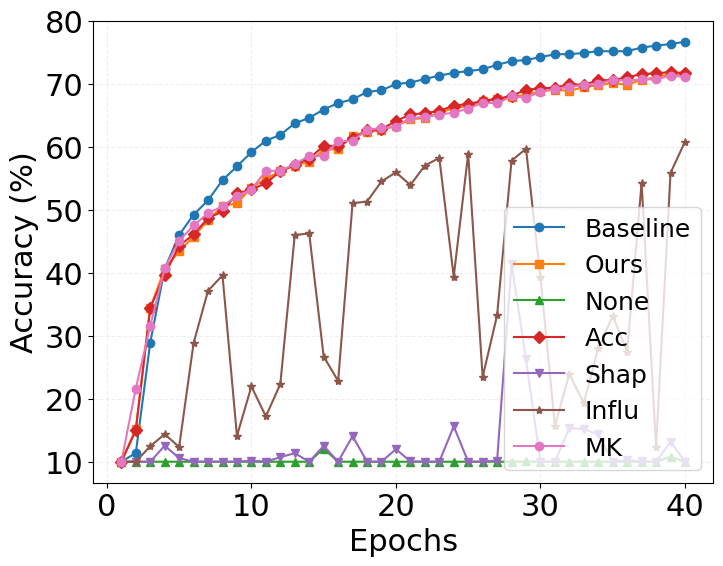

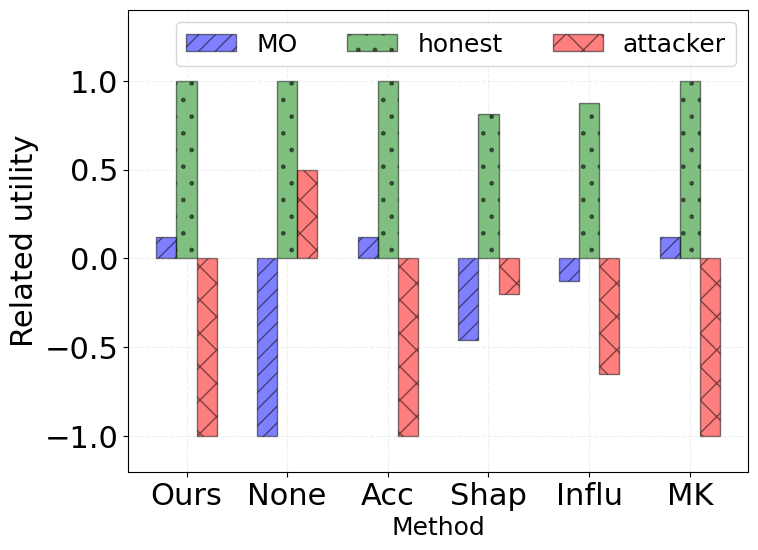

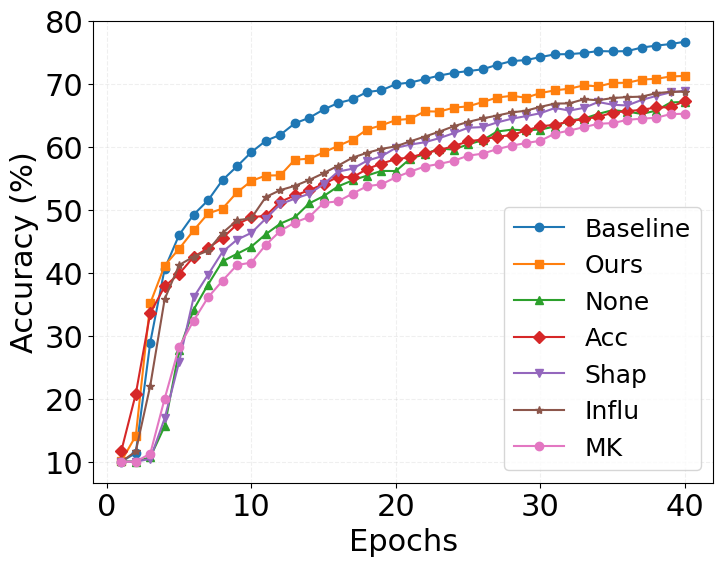

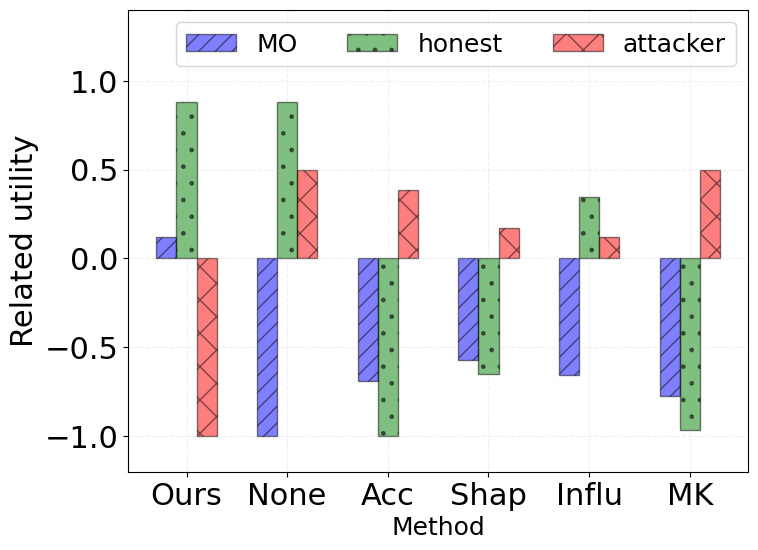

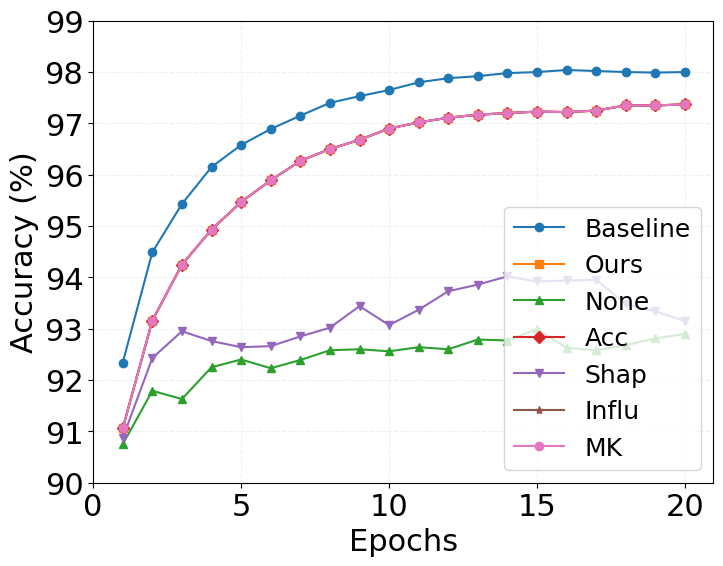

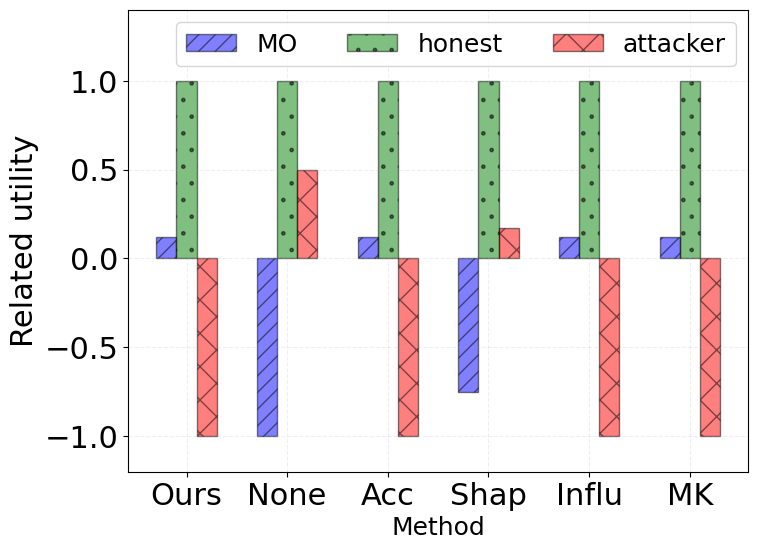

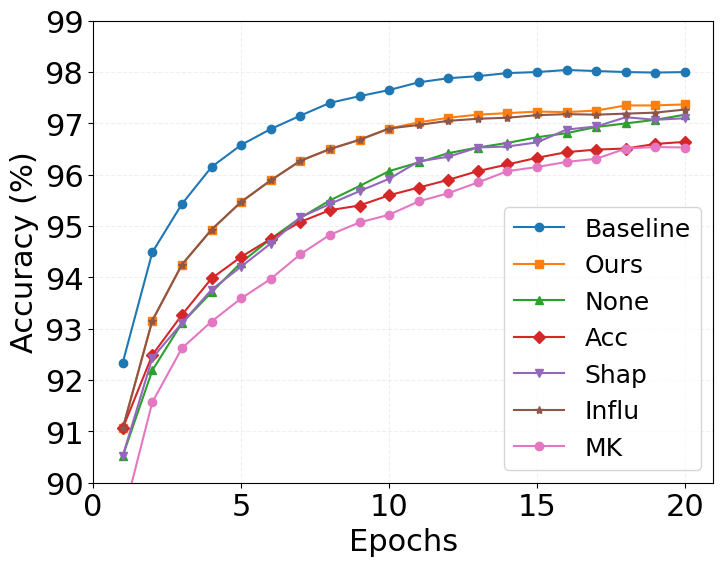

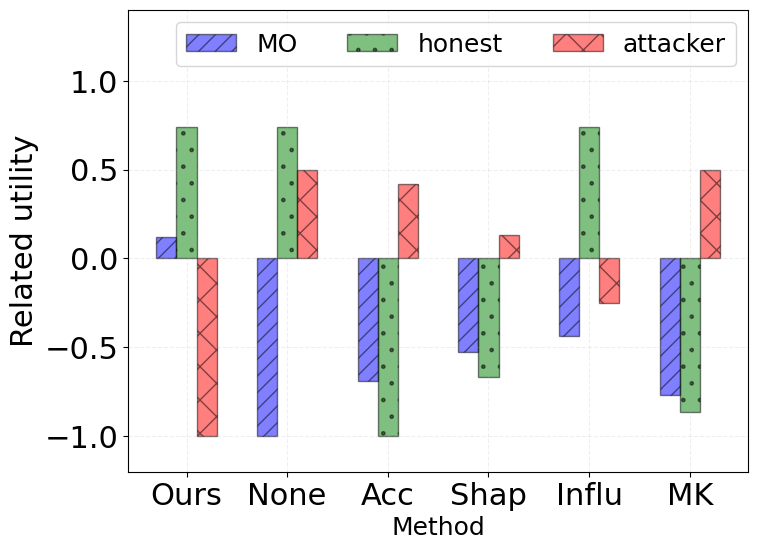

In [40]:
def plot_accuracy_curves(accuracy_lists, labels, save_name):
    """
    绘制多个模型的测试集准确率折线图。

    参数:
    accuracy_lists: 不定数量的列表，每个列表包含一个模型在各个EPOCH的测试集准确率
    """
    # 计算最大EPOCH数
    max_epochs = max(len(accuracy_list) for accuracy_list in accuracy_lists)
    epochs = range(1, max_epochs + 1)

    # 绘制折线图
    plt.figure(figsize=(8, 6))
    markers = ["o", "s", "^", "D", "v", "*"]  # 一些预定义的标记符号
    for i, accuracy_list in enumerate(accuracy_lists):
        marker = markers[i % len(markers)]  # 循环使用标记符号
        plt.plot(
            epochs[: len(accuracy_list)], accuracy_list, marker=marker, label=labels[i]
        )

    # 添加图表标题和标签
    # plt.title("Test Accuracy Over Epochs")
    plt.yticks(fontsize=22)
    print(np.arange(0, max_epochs + 1, max_epochs / 4))
    plt.xlabel("Epochs", fontsize=22)
    plt.ylabel("Accuracy (%)", fontsize=22)
    plt.legend(loc="lower right", fontsize=18)
    plt.grid(ls="--", alpha=0.2)
    if save_name == "task2_4_0" or save_name == "task2_0_4":
        plt.ylim(90, 99)
    plt.xticks(np.arange(0, max_epochs + 1, max_epochs / 4), fontsize=22)

    # 显示图表
    plt.savefig(f"figures/acc_{save_name}.pdf", dpi=300, bbox_inches="tight")


def plot_utility(mo_util, ho_util, atk_util, labels, save_name):
    # 将数据转换为numpy数组
    mo_util = np.array(mo_util)
    ho_util = np.array(ho_util)
    atk_util = np.array(atk_util)

    # 归一化数据，使其在-1到1之间
    def normalize(data):
        max_val = np.max(np.abs(data))
        return data / max_val

    mo_util_norm = normalize([sum(tmp) for tmp in mo_util])
    ho_util_norm = normalize([sum(tmp) for tmp in ho_util])
    atk_util_norm = normalize([sum(tmp) for tmp in atk_util])

    # 设置柱状图参数
    x = np.arange(len(mo_util))  # 方案的数量
    width = 0.2  # 柱状图的宽度

    # 绘制分组柱状图
    plt.figure(figsize=(8, 6))
    bars1 = plt.bar(
        x - width,
        mo_util_norm,
        width,
        label="MO",
        hatch="//",
        edgecolor="k",
        alpha=0.5,
        color="b",
    )
    bars2 = plt.bar(
        x,
        ho_util_norm,
        width,
        label="honest",
        hatch=".",
        edgecolor="k",
        alpha=0.5,
        color="g",
    )
    bars3 = plt.bar(
        x + width,
        atk_util_norm,
        width,
        label="attacker",
        hatch="x",
        edgecolor="k",
        alpha=0.5,
        color="r",
    )

    # 添加标签和标题
    plt.yticks(fontsize=22)
    plt.xticks(x, fontsize=22, labels=labels)
    plt.xlabel("Method", fontsize=18)
    plt.ylabel("Related utility", fontsize=22)
    plt.legend(loc="upper right", ncol=3, fontsize=18)
    plt.grid(ls="--", alpha=0.2)
    plt.ylim(-1.2, 1.4)

    # 显示图形
    plt.savefig(f"figures/util_{save_name}.pdf", dpi=300, bbox_inches="tight")


paras1_1 = [
    (1, 0, 0, 0, 46),
    (1, 6, 4, 0, 46),
    (1, 0, 4, 0, 46),
    (1, 1, 4, 0, 46),
    (1, 2, 4, 0, 46),
    (1, 3, 4, 0, 46),
    (1, 4, 4, 0, 46),
    # (1, 5, 4, 0, 46),
]

paras1_2 = [
    (1, 0, 0, 0, 46),
    (1, 6, 0, 4, 46),
    (1, 0, 0, 4, 46),
    (1, 1, 0, 4, 46),
    (1, 2, 0, 4, 46),
    (1, 3, 0, 4, 46),
    (1, 4, 0, 4, 46),
    # (1, 5, 0, 4, 46),
]

paras2_1 = [
    (2, 0, 0, 0, 46),
    (2, 6, 4, 0, 46),
    (2, 0, 4, 0, 46),
    (2, 1, 4, 0, 46),
    (2, 2, 4, 0, 46),
    (2, 3, 4, 0, 46),
    (2, 4, 4, 0, 46),
    # (2, 5, 4, 0, 46),
]

paras2_2 = [
    (2, 0, 0, 0, 46),
    (2, 6, 0, 4, 46),
    (2, 0, 0, 4, 46),
    (2, 1, 0, 4, 46),
    (2, 2, 0, 4, 46),
    (2, 3, 0, 4, 46),
    (2, 4, 0, 4, 46),
    # (2, 5, 0, 4, 46),
]

labels = [
    "Baseline",
    "Ours",
    "None",
    "Acc",
    "Shap",
    "Influ",
    "MK",
    # "Signi",
]


# 绘制各验证方法对效用值的影响
# def test_util(paras, save_name):
#     ret = data_preprocess(paras, "list")
#     plot_utility(
#         [item[3] for item in ret],
#         [item[4] for item in ret],
#         [item[5] for item in ret],
#         labels,
#         save_name,
#     )


# 绘制收敛曲线和效用值柱状图
for para, save_name in zip(
    [paras1_1, paras1_2, paras2_1, paras2_2],
    ["task1_4_0", "task1_0_4", "task2_4_0", "task2_0_4"],
):
    ret = data_preprocess(para, "list")
    plot_accuracy_curves([item[0] for item in ret], labels, save_name)
    plot_utility(
        [item[3] for item in ret][1:],
        [item[4] for item in ret][1:],
        [item[5] for item in ret][1:],
        labels[1:],
        save_name,
    )

# 展示验证准确率
# veri_acc_honest = [np.average(item[1]) for item in ret]
# veri_acc_attacker = [np.average(item[2]) for item in ret]
# print(veri_acc_honest, veri_acc_attacker)

# 展示参与者效用
# mo_utility = [np.sum(item[3]) for item in ret]
# tn_utilities_honset = [np.sum(item[4]) for item in ret]
# tn_utilities_attacker = [np.sum(item[5]) for item in ret]
# print(mo_utility,tn_utilities_honset,tn_utilities_attacker)